### Elective Lab 1/3: Lab 5b
#### Katie Robinson

Add foxes that prey on rabbits to Daisy World. By changing the various degrees of freedom in this problem, look for “predator-prey” oscillations, in which the fox and rabbit populations go through periodic highs and lows. Hand-in a discussion and plots describing and showing the most interesting oscillations/longest non-trivial steady state you can find.

** Note: I changed my daisy and rabbit equations slightly based on your comments from my lab 5a. In this new version, rabbits can still occupy land where daisies are, and if the rabbit population goes to zero, daisies can still die of natural causes (ie. I changed the equation so that the death rate = $\chi(1+A_R)$). Similarly, rabbits can still die if the fox population goes to zero.

Below is a summary of my daisy world model:

The concentration of white and black daisies changes over time according to $$\frac{dA_b}{dt} = A_b(\beta_b x-\chi_b(1+ A_R)),$$ $$\frac{dA_w}{dt} = A_w(\beta_w x-\chi_w(1+ A_R)),$$ where $A_i$ (i=b,w) is the fractions of total planetary area covered by black and white daisies, and $\beta_i$ is the growth rate of black and white daises and is proportional to the amount of free growing area on the planet, $$x = 1 - A_w - A_b.$$ 
I chose to define the "bare ground" as the amount of land not occupied by any daisies, since daisies can still grow where there are rabbits/foxes and vice versa (foxes/rabbits can exist where there are daisies). 

$\chi_i$ is the death rate of black and white daisies and is proportional to the amount of rabbits ($A_R$). However, even if the population of rabbits is zero, the daises can still die of natural causes.

The population of rabbits changes over time according to $$\frac{dR}{dt} = A_R(\beta_R(1-x)-\chi_R(1+A_F)),$$ where $\beta_R$ is the rabbit growth rate (proportional to the amount of daisies) and $\chi_R$ is the rabbit death rate (proportional to the amount of foxes). 

Finally, the population of foxes changes over time according to $$\frac{dF}{dt} = A_F(\beta_F(A_R)-\chi_F),$$ where $\beta_F$ is the fox growth rate (proportional to the area occupied by rabbits) and $\chi_F$ is the fox death rate.

My adapted integrator class that includes the feedback between all the different species is included below:

In [89]:
# functions for problem initial
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# New integrator class that includes rabbits AND foxes

class Rabbits(Integrator):
    def set_yinit(self,new_blackconc,new_whiteconc,bunny_conc,fox_conc):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        self.config["initvars"]["blackconc"] = new_blackconc
        self.config["initvars"]["whiteconc"] = new_whiteconc
        self.config["initvars"]["bunnyconc"] = bunny_conc
        self.config["initvars"]["foxconc"] = fox_conc
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array([self.initvars.whiteconc, self.initvars.blackconc,self.initvars.bunnyconc,self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return self.yinit

    def __init__(self, coeff_file_name,new_blackconc,new_whiteconc,bunny_conc,fox_conc):
        super().__init__(coeff_file_name)
        self.set_yinit(new_blackconc,new_whiteconc,bunny_conc,fox_conc)
        #self.set_yinit(new_whiteconc)
        self.blackconc = new_blackconc
        self.whiteconc = new_whiteconc
        self.bunnyconc = bunny_conc
        self.foxconc = bunny_conc

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction of bunnies
           y[3]=fraction of foxes
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[3] = y[3] * (user.beta_f * (y[2]) - user.chiF)
        f[2] = y[2] * (user.beta_r * (1-bare) - user.chiR*(1+f[3]))
        f[0] = y[0] * (beta_w * bare - user.chi*(1+f[2]))
        f[1] = y[1] * (beta_b * bare - user.chi*(1+f[2]))
        
        return f

Testing the model:

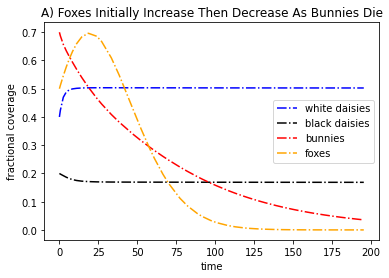

In [121]:
Predators = Rabbits('adapt.yaml',0.2,0.4,0.7,0.5)
timeVals, yVals, errorList = Predators.timeloop5Err()

yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black','bunnies','foxes'])
#yVals

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-.b', label='white daisies')
#points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '-.k', label='black daisies')
theLine2, = theAx.plot(timeVals, yvals['bunnies'], '-.r', label='bunnies')
theLine3, = theAx.plot(timeVals, yvals['foxes'], color='orange',linestyle='-.', label='foxes')
theAx.set_title('A) Foxes Initially Increase Then Decrease As Bunnies Die')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

In the case shown above, the population of foxes initially increases, causing the rabbit population to decline. However, as rabbit population declines further, the fox population reaches a turning point (ie. where there are not enough rabbits to sustain the growing fox population), and begins to decline. The fraction of white daisies intially increases in response to decline rabbits, but then stabilizes (both species of daises tend to reach equilibrium faster than the fox and rabbit populations in most of my tests).

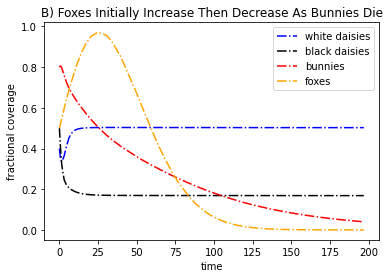

In [120]:
Predators = Rabbits('adapt.yaml',0.5,0.4,0.8,0.5)
timeVals, yVals, errorList = Predators.timeloop5Err()

yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black','bunnies','foxes'])
#yVals

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-.b', label='white daisies')
#points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '-.k', label='black daisies')
theLine2, = theAx.plot(timeVals, yvals['bunnies'], '-.r', label='bunnies')
theLine3, = theAx.plot(timeVals, yvals['foxes'], color='orange',linestyle='-.', label='foxes')
theAx.set_title('B) Foxes Initially Increase Then Decrease As Bunnies Die')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

Similarily to plot A, the fox population initially increases but subsequently decreases as rabbit populations decline. The popoulation of white daises initially decreases but then increases in response to decreasing black daisies, before both daisies reach steady state.

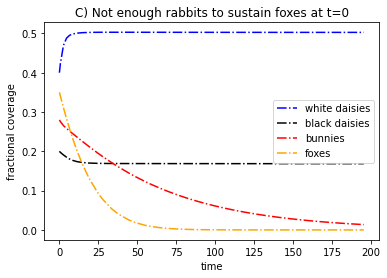

In [125]:
Predators = Rabbits('adapt.yaml',0.2,0.4,0.28,0.35)
timeVals, yVals, errorList = Predators.timeloop5Err()

yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black','bunnies','foxes'])
#yVals

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-.b', label='white daisies')
#points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '-.k', label='black daisies')
theLine2, = theAx.plot(timeVals, yvals['bunnies'], '-.r', label='bunnies')
theLine3, = theAx.plot(timeVals, yvals['foxes'], color='orange',linestyle='-.', label='foxes')
theAx.set_title('C) Not enough rabbits to sustain foxes at t=0')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

In case C (above), the initial population of foxes is greater than the intial population of rabbits. It appears that the intial rabbit population is not large enough to sustain the foxes, and both populations decline. I suspect that in order to see the interesting oscillatory patterns in plots A and B, the initial concentration of rabbits needs to be larger than foxes. 

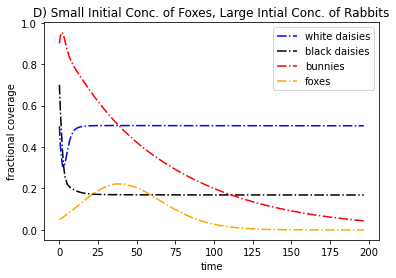

In [133]:
Predators = Rabbits('adapt.yaml',0.7,0.5,0.9,0.05)
timeVals, yVals, errorList = Predators.timeloop5Err()

yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black','bunnies','foxes'])
#yVals

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-.b', label='white daisies')
#points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '-.k', label='black daisies')
theLine2, = theAx.plot(timeVals, yvals['bunnies'], '-.r', label='bunnies')
theLine3, = theAx.plot(timeVals, yvals['foxes'], color='orange',linestyle='-.', label='foxes')
theAx.set_title('D) Small Initial Conc. of Foxes, Large Intial Conc. of Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

For plot D, I tested the effects of having a very low intial concentration of foxes and a very high initial concentration of rabbits. Initially, the rabbit population increases as a result of the low amount of predators, but this causes the fox population to increase and the rabbits subsequently decrease. Then (as in the other cases), decreased rabbits causing the rising fox populations to also decrease and evolve into a state of equilibrium. Surprisingly, the fox population never surpasses the rabbit population, even at its peak. This indicates that the fox population exerts a strong control on the rabbit population and can cause rabbits to decrease rapidly even when the rabbits greatly outnumber the foxes.

In general I have observed that when the initial concentration of rabbits is higher than the initial population of foxes, the same oscillatory pattern occurs where foxes increase quickly in response to the large rabbit populations, causing rabbit populations to decline. Eventually, the decrease in rabbits causes the foxes to start decreasing until the two populations reach an equilibrium, often at very low fractional areas of the planet.

When the intial fox population is very low, the rabbits have a chance to increase, but are quickly dampened by the resulting growing fox populations. 